# Idler data
This notebook demonstrates the power of using topology in bearing fault detection tasks on industrial data

In [1]:
#imports
import numpy as np
import gudhi as gd
from gudhi.representations import BettiCurve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from tqdm.notebook import tqdm 
import matplotlib
import h5py
from TDASignaltools import cvb, compute_diagram
from scipy.signal import spectrogram


In [2]:
#load data
datapath ="./Dlotko_dane/text_files/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
signal_list = []
for filename in sorted(filelist):
    signal_list.append(np.loadtxt(datapath+filename))
    

['good_cond_Gauss.txt', 'good_cond_Gauss_ch_b.txt', 'sig1a.txt', 'sig1b.txt', 'sig2a.txt', 'sig2b.txt', 'sig3a.txt', 'sig3b.txt']


* signal 1 is good condition non-gaussian noise
* signal 2 is bad condition gaussian noise
* signal 3 is bad condition non-gaussian noise

In [3]:
#cut timeseries to ensure common length
minlengeth = min([len(s) for s in signal_list])
for i in range(len(signal_list)):
    signal_list[i] = signal_list[i][:minlengeth]

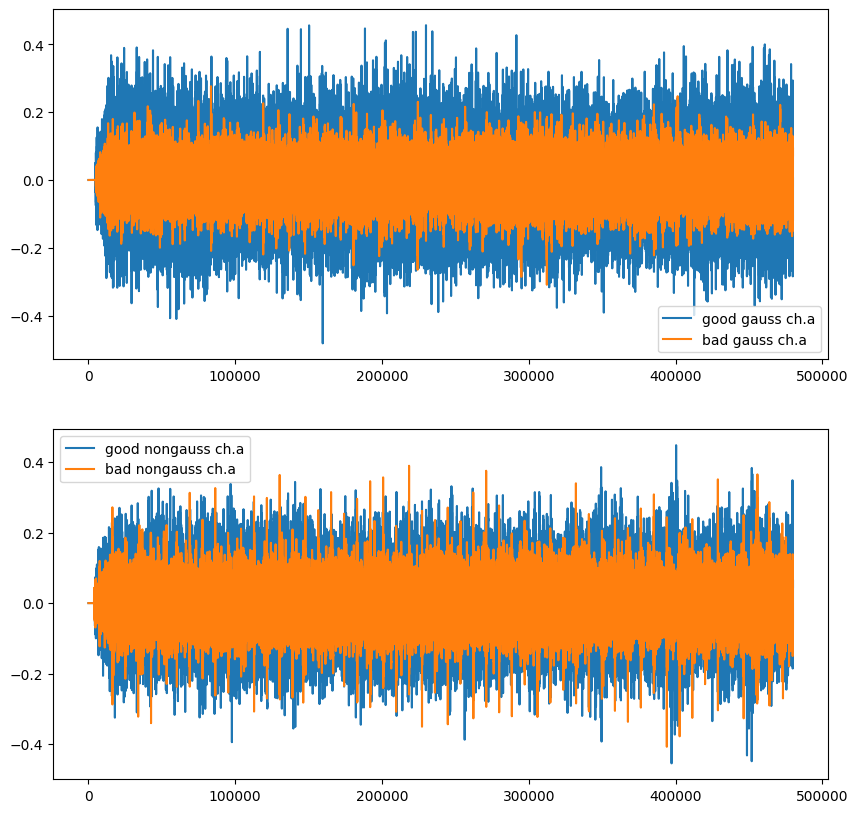

In [4]:
#plot some examples
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(signal_list[0], label = "good gauss ch.a")
ax[0].plot(signal_list[4], label = "bad gauss ch.a")
ax[0].legend()


ax[1].plot(signal_list[2], label = "good nongauss ch.a")
ax[1].plot(signal_list[6], label = "bad nongauss ch.a")
ax[1].legend()
plt.show()

In [5]:
#compute betti curves
n_samples = 10
start = 2.9
end = 3.5
grid = np.linspace(start,end,257)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((len(signal_list),n_samples,len(grid)))




for j in tqdm(range(0,len(signal_list))):
    dim = 96
    delay = 98
    skip =1
    samples = np.array_split(signal_list[j],n_samples)
        
    for k in range(0,len(samples)):
        pd = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100)    
        curve = np.array(bc.fit_transform([pd])[0])
        betti_curves[j,k] = curve


  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
#compute cvb

cvb_curves = np.zeros((len(signal_list),n_samples,257))

for j in tqdm(range(0,len(signal_list))):

    samples = np.array_split(signal_list[j],n_samples)
        
    for k in range(0,len(samples)):
        freqs, t, Pxx = spectrogram(samples[k], fs=25000, nfft=512, window="hamming", nperseg= 256, noverlap= int(np.floor(0.85*256)),detrend = False, mode="magnitude")
        curve =  np.array([cvb(np.abs(Pxx[i])) for i in range(0,len(freqs))])
        
        cvb_curves[j,k] = curve

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
#uncomment one of the following three lines depending on whether you are interested in Betti curve, CVB or a combination
#curves = betti_curves
#curves = cvb_curves
curves = np.concatenate([betti_curves, (np.max(betti_curves)/np.max(cvb_curves))*cvb_curves],axis = 2)
norms = np.zeros((len(signal_list),n_samples))
for i in range(len(signal_list)):
    for j in range(n_samples):
        norms[i,j] = np.sum(np.abs(curves[i,j]))

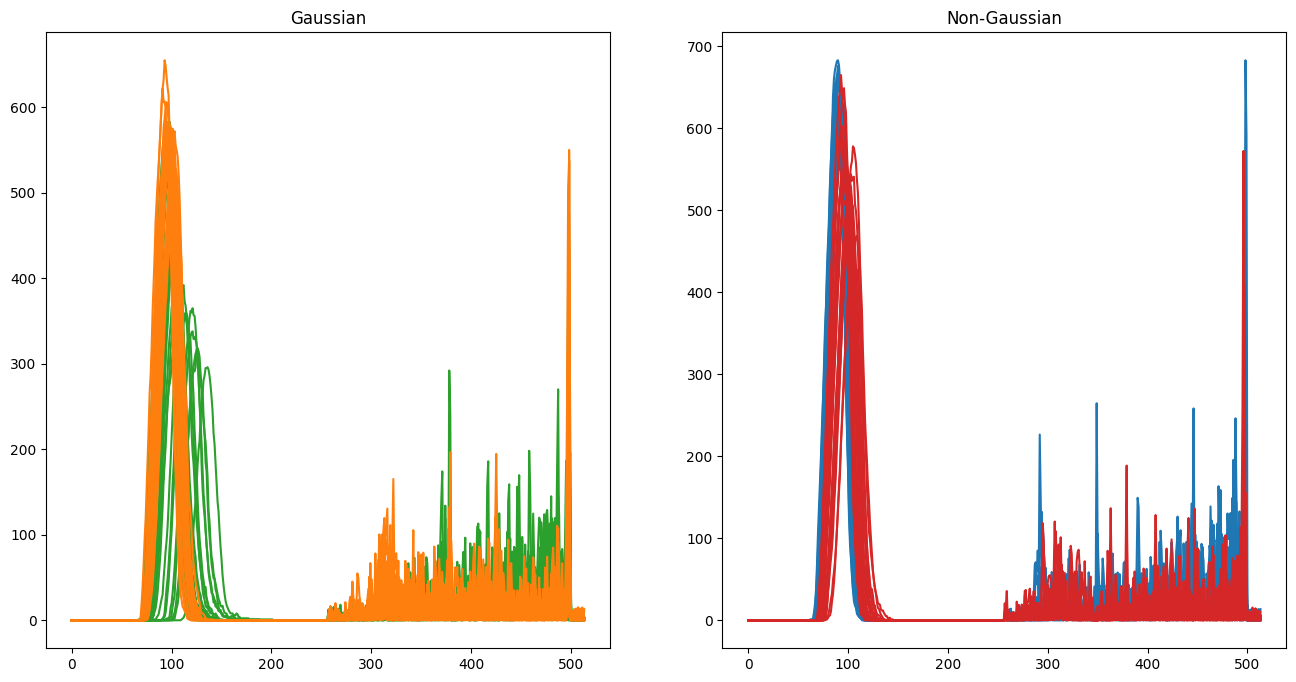

In [8]:
#plot the curves

colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]

f,ax = plt.subplots(1,2,figsize=(16,8))
for j in [0,1,4,5]:
    for k in range(0,len(samples)):
        ax[0].plot( curves[j][k], color=colors[j//2])
for j in [2,3,6,7]:
    for k in range(0,len(samples)):
        ax[1].plot( curves[j][k], color=colors[j//2])
        
ax[0].set_title("Gaussian")
ax[1].set_title("Non-Gaussian")
plt.show()

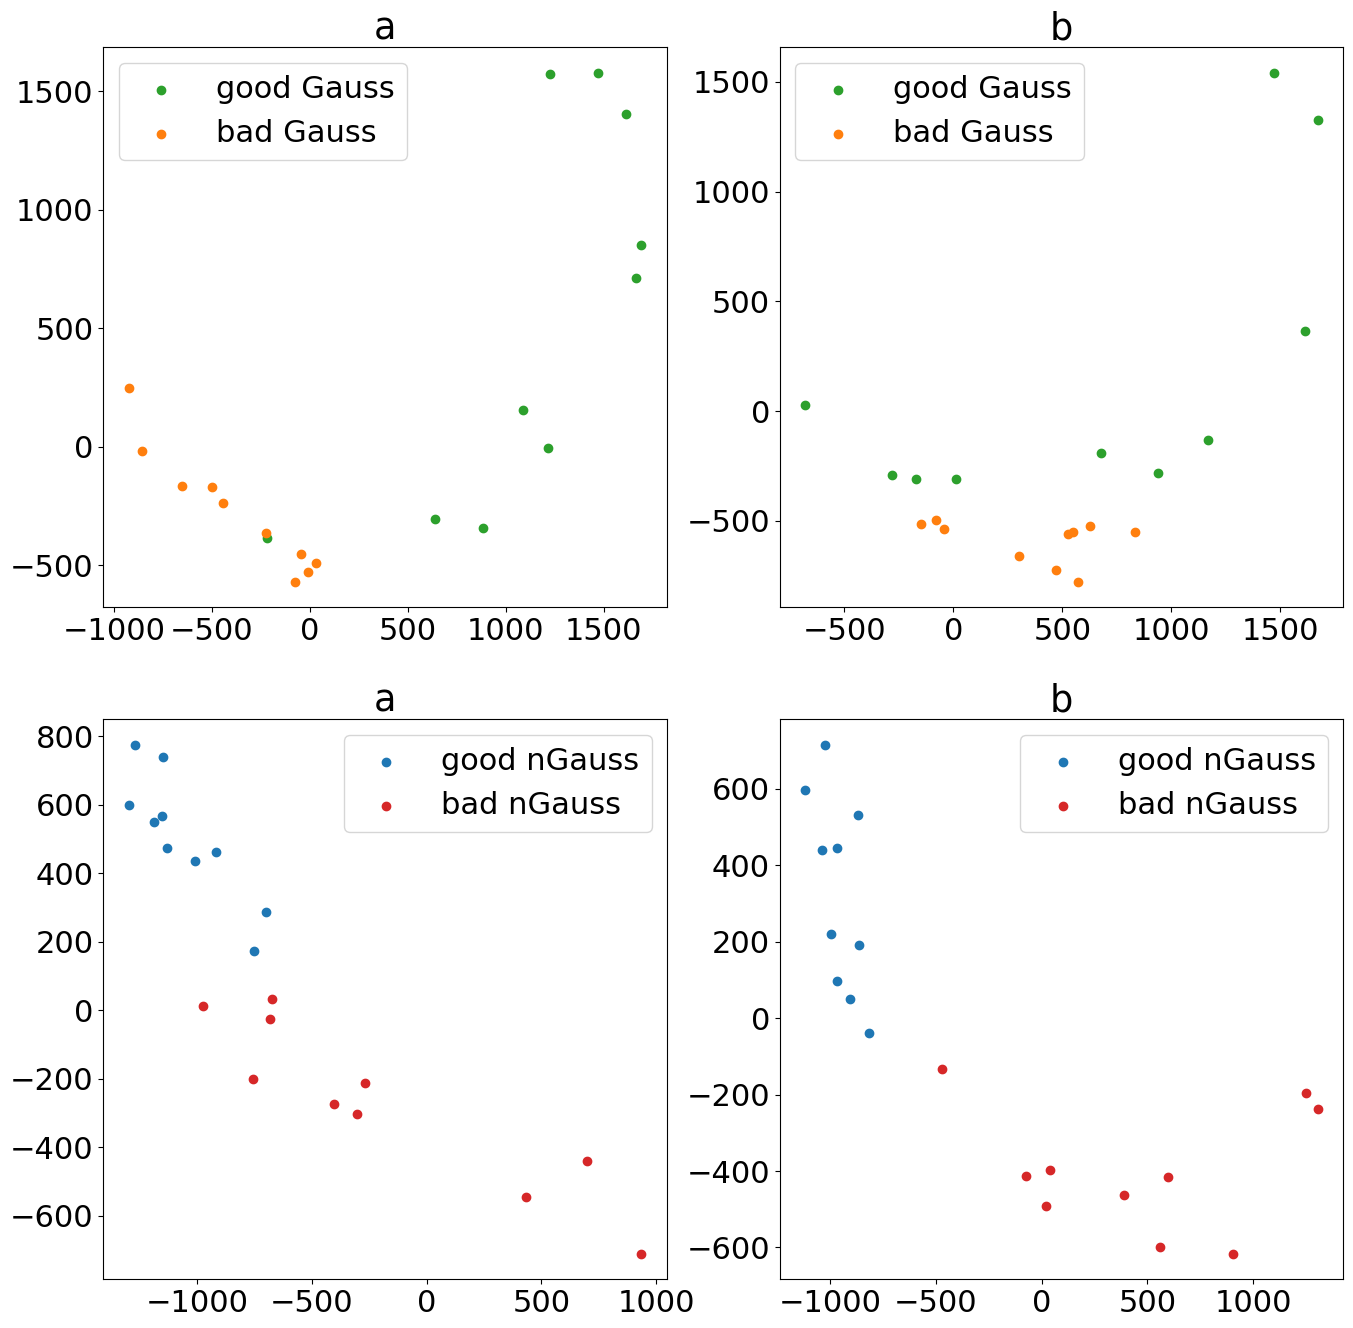

explained variance: [0.60384132 0.25119157 0.03219087]
silhouette score 0.0972963580193261


In [9]:
#plot pca

plt.rc('font', **{'size'   : 22})
pca = PCA(n_components=3)
pca.fit_transform([curves[j,k] for j in range(0,len(signal_list)) for k in range(0,n_samples)])
labels = np.repeat([1,2,3,4], 2*n_samples)
names = ["good Gauss", "good nGauss", "bad Gauss", "bad nGauss"]
fig,ax = plt.subplots(2,2,figsize=(16,16))
##############ch.a:0,2 ----------ch.b:1,3
for i in [0,2]:
    
    emb_a = pca.transform(curves[2*i,:])
    ax[0,0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=names[i])    
    ax[0,0].set_title("a")
    ax[0,0].legend()
    
    emb_b = pca.transform(curves[2*i+1,:])
    ax[0,1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=names[i])
    ax[0,1].set_title("b")
    ax[0,1].legend()

for i in [1,3]:
    
    emb_a = pca.transform(curves[2*i,:])
    ax[1,0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=names[i])    
    ax[1,0].set_title("a")
    ax[1,0].legend()
    
    emb_b = pca.transform(curves[2*i+1,:])
    ax[1,1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=names[i])
    ax[1,1].set_title("b")
    ax[1,1].legend()
    

plt.savefig("results/IdlerPCA.pdf")
plt.show()
print("explained variance:", pca.explained_variance_ratio_)
print("silhouette score",silhouette_score(curves.reshape(8*n_samples, curves.shape[2]), labels))

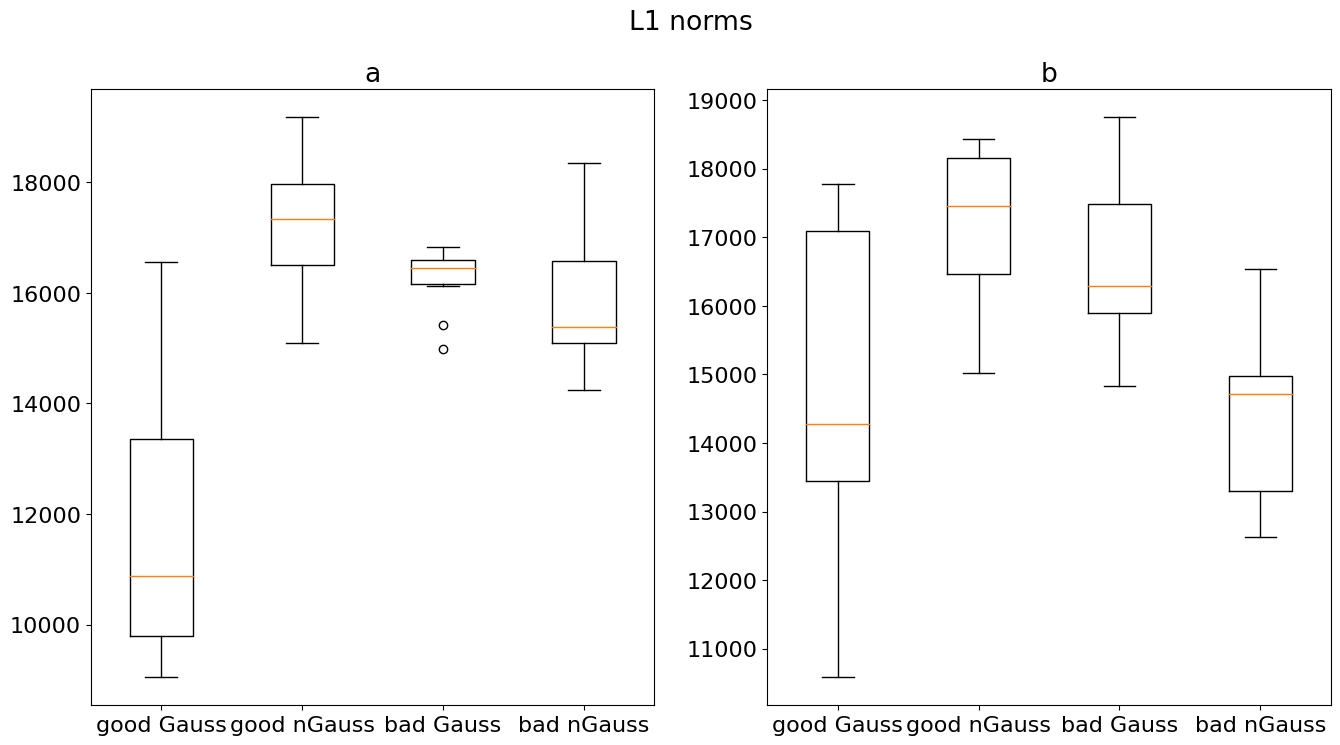

In [10]:
#plot boxplot of norms 

plt.rc('font', **{'size'   : 16})
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].boxplot([norms[0,:],norms[2,:],norms[4,:],norms[6,:]])
ax[0].set_title("a")
ax[0].set_xticklabels(names)
 
ax[1].boxplot([norms[1,:],norms[3,:],norms[5,:],norms[7,:]])
ax[1].set_title("b")
ax[1].set_xticklabels(names)
          
fig.suptitle("L1 norms")
plt.savefig("results/IdlerBoxplot.pdf")
plt.show()

In [11]:
n_iterations = 100
#gauss
X=np.array([curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)])
y = np.repeat([0,1], 2*n_samples)
gauss_score_list = []
gauss_svnorm_list = []
for seed in range(n_iterations):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    gauss_score_list.append(clf.score(X_test, y_test))
    gauss_svnorm_list.append(np.linalg.norm(clf.coef_[0]))

#nGauss
X=np.array([curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)])
y = np.repeat([0,1], 2*n_samples)
from sklearn.model_selection import train_test_split
ngauss_score_list = []
ngauss_svnorm_list = []
for seed in range(n_iterations):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    ngauss_score_list.append(clf.score(X_test, y_test))
    ngauss_svnorm_list.append(np.linalg.norm(clf.coef_[0]))

Gauss mean, std: 0.932 0.060216276869298375
nGauss mean, std: 0.9610000000000001 0.045044422518220835


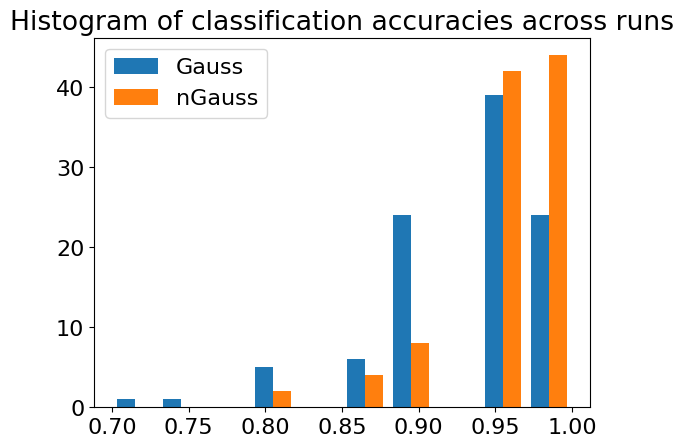

In [12]:
plt.hist([gauss_score_list, ngauss_score_list], label=(["Gauss", "nGauss"]))
plt.legend()
plt.title("Histogram of classification accuracies across runs")
print("Gauss mean, std:", np.mean(gauss_score_list), np.std(gauss_score_list))
print("nGauss mean, std:", np.mean(ngauss_score_list), np.std(ngauss_score_list))

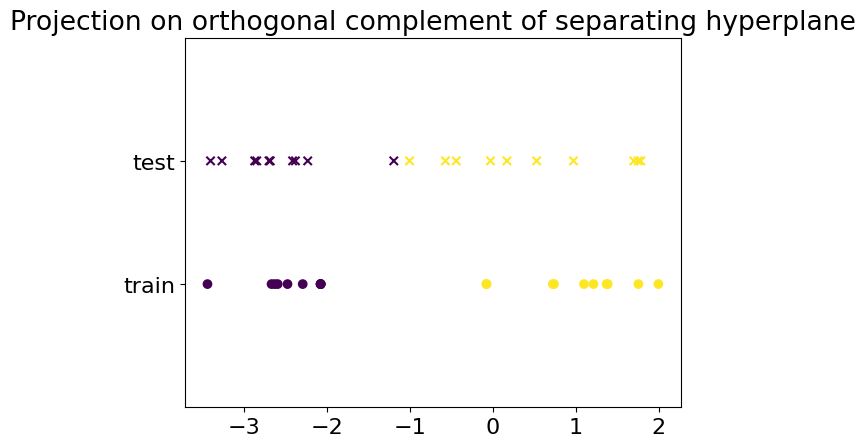

In [13]:
f,ax = plt.subplots()
projection = np.dot(X_train, clf.coef_[0])
ax.scatter(projection, [0]*2*n_samples, c=y_train)
projection = np.dot(X_test, clf.coef_[0])
ax.scatter(projection, [0.1]*2*n_samples, c=y_test, marker="x")

ax.set_ylim((-0.1,0.2))
ax.set_yticks([0,0.1])
ax.set_yticklabels(["train","test"])

plt.title("Projection on orthogonal complement of separating hyperplane")
plt.show()